# Session 5 - Step 4

## Target

    99.4% (this must be consistently shown in your last few epochs, and not a one-time achievement).
    Less than or equal to 15 Epochs.
    Less than 10000 Parameters (additional points for doing this in less than 8000 pts).


## Result
    Parameter Count: 7002
    Accuracies in this run, at 14th Epoch:
    Training Average loss: 0.019206, Accuracy = (99.376667%)
    Test set: Average loss: 0.016352, Accuracy: 9951/10000 (99.510000%)
    Target achieved in 14th Epoch with 99.51%, after which it stays above 99.39% in next 5 Epochs.

## Analysis
### Model Architecture
Tried to use the spare capacity (~1K) to increase filters in first layer, by increasing from 8 to 10/12. But this proved counterintuitive, as it somehow stopped test accuracy from going beyond 99.31%

### Learning Rate Scheduling
Used LR schedular with higher learning rates to aggresively achieve target.
Adjusted the schedule to reduce LR when the model started deteorating at 12th Epoch.

0.1 for epoch 1-9

0.05 for epoch 10-12

0.01 for epoch 13-14

0.01 for epoch 15-19

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Model Architecture
8 -> 16 -> MP -> (1x1) -> 8 -> 16 -> 20 -> (1x1) -> 8 -> 16 -> GAP -> Dense -> 10

##Download the dataset


### Data Augmentation added:
1. Rotation: -5 to +5 degrees.
2. Shear:    -5 to +5 degrees in x axis. (y axis shear/slant not practical for human handwriting)

Rotation was added, as suggested in Class. But the quantity was reduced to 5 from 7 degrees as Shear started to further exaggerate its effect. The fill was done with -0.42 as it matches white background (found by checking minimum in individual image).


### Data Augmentation experimented with:
1. Translate/Shift: 10% in x and y axis.
2. Scale: 10% in x in y axis.

There are some images in dataset which are already very close to the boundry. Example which i saw was a Zero, which had its edge cut off by the vertical shift. So, these augmentations were avoided.

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #transforms.ToPILImage(),
                                      #transforms.Resize((28, 28)),
                                      #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(0.13,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       #transforms.RandomRotation((-5.0, 5.0), fill=(-0.42,)),
                                       transforms.RandomAffine((-5,5), translate=None, scale=None, shear=5, resample=False, fillcolor=(-0.42,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1315: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1329: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  "Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead"


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.3901)
 - std: tensor(0.2874)
 - var: tensor(0.0826)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([64, 1, 28, 28])
torch.Size([64])


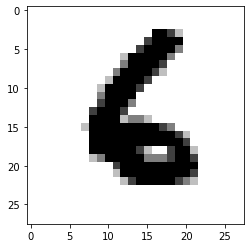

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


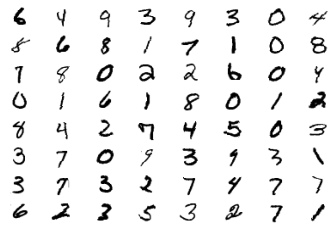

In [ ]:
figure = plt.figure()
num_of_images = 64
for index in range(1, num_of_images + 1):
    plt.subplot(8, 8, index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')

In [ ]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## Utility Functions

In [ ]:
# from tqdm.notebook import tqdm

#Use scheduler
def train(model, device, train_loader, optimizer, scheduler, epoch):
    model.train()
    # pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    num_loops = 0
    # for batch_idx, (data, target) in enumerate(pbar):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        num_loops +=1
 
    train_loss /= num_loops
    # scheduler.step()
    scheduler.step(train_loss)
    hist_train_loss.append(train_loss)
    hist_train_acc.append(100. * correct / len(train_loader.dataset))
    print("Training Average loss: {:.6f}, Accuracy = ({:.6f}%)".format(train_loss, 100. * correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    hist_test_loss.append(test_loss)
    hist_test_acc.append(100. * correct / len(test_loader.dataset))

    print('Test set: Average loss: {:.6f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('model.py','wb').write(src)
import model

Saving model.py to model (1).py


In [ ]:
model_GN = model.Net3_1("GN").to(device)
summary(model_GN, input_size=(1, 28, 28))

Normalization Technique:  GN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
             ReLU-11            [-1, 8, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           1,152
             ReLU-13           [-1, 16, 10, 10]               0
        Gr

# Model

Uses Dropout of 0.05 at every layer.

Uses BatchNormalization.

Uses fully connected after GAP at final layer.



In [ ]:
input = torch.randn(20, 5, 10, 10)

In [ ]:
input.size()[1:]

torch.Size([5, 10, 10])

# Training

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 6]

def training_curves():
  plt.subplot(1,2, 1)

  plt.plot(np.array(hist_test_acc))
  plt.plot(np.array(hist_train_acc), 'r')
  plt.legend(["test_acc", "train_acc"])
  plt.title("Accuracy per epoch")

  plt.subplot(1,2,2)
  plt.plot(hist_test_loss)
  plt.plot(hist_train_loss, 'r')
  plt.legend(["test_loss", "train_loss"])
  plt.title("Loss per epoch")

In [ ]:
hist_test_loss = []
hist_test_acc = []
hist_train_loss = []
hist_train_acc = []

In [ ]:
model_training_loss = dict()
model_training_acc = dict()
model_testing_loss = dict()
model_testing_acc = dict()

## Training with Group Norm

Epoch:  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training Average loss: 0.305539, Accuracy = (89.990000%)
learning rate 0.1
Test set: Average loss: 0.071890, Accuracy: 9778/10000 (97.780000%)

Epoch:  2
Training Average loss: 0.090569, Accuracy = (97.246667%)
learning rate 0.1
Test set: Average loss: 0.053111, Accuracy: 9837/10000 (98.370000%)

Epoch:  3
Training Average loss: 0.069444, Accuracy = (97.848333%)
learning rate 0.1
Test set: Average loss: 0.044312, Accuracy: 9864/10000 (98.640000%)

Epoch:  4
Training Average loss: 0.059423, Accuracy = (98.176667%)
learning rate 0.1
Test set: Average loss: 0.035671, Accuracy: 9890/10000 (98.900000%)

Epoch:  5
Training Average loss: 0.053797, Accuracy = (98.310000%)
learning rate 0.1
Test set: Average loss: 0.035002, Accuracy: 9881/10000 (98.810000%)

Epoch:  6
Training Average loss: 0.048056, Accuracy = (98.550000%)
learning rate 0.1
Test set: Average loss: 0.030778, Accuracy: 9906/10000 (99.060000%)

Epoch:  7
Training Average loss: 0.044962, Accuracy = (98.578333%)
learning rate 0.1
T

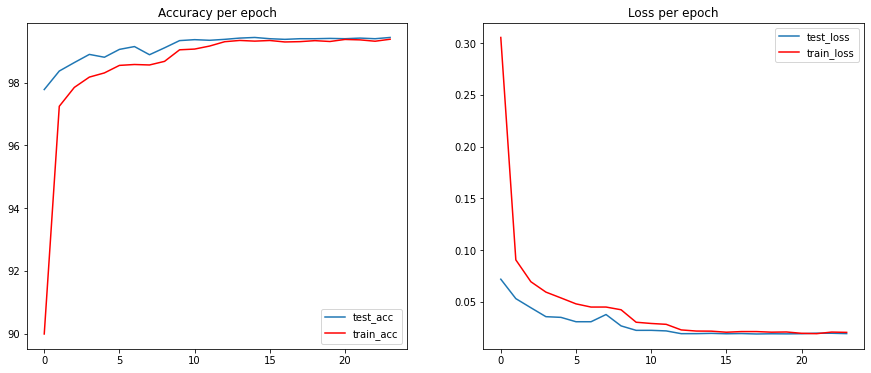

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR

optimizer = optim.SGD(model_GN.parameters(), lr=0.1, momentum=0.9,)

scheduler =ReduceLROnPlateau(optimizer=optimizer, patience=2, verbose=True)

for epoch in range(1, 10):
    print("Epoch: ", epoch)
    train(model_GN, device, train_loader, optimizer, scheduler, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model_GN, device, test_loader)

optimizer = optim.SGD(model_GN.parameters(), lr=0.05, momentum=0.9)
for epoch in range(10, 13):
    print("Epoch: ", epoch)
    train(model_GN, device, train_loader, optimizer, scheduler, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model_GN, device, test_loader)

optimizer = optim.SGD(model_GN.parameters(), lr=0.01, momentum=0.9)
for epoch in range(13, 25):
    print("Epoch: ", epoch)
    train(model_GN, device, train_loader, optimizer, scheduler, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model_GN, device, test_loader)

training_curves()

Epoch:  15


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training Average loss: 0.022003, Accuracy = (99.293333%)
learning rate 0.01
Test set: Average loss: 0.021322, Accuracy: 9937/10000 (99.370000%)

Epoch:  16
Training Average loss: 0.019849, Accuracy = (99.376667%)
learning rate 0.01
Test set: Average loss: 0.020452, Accuracy: 9938/10000 (99.380000%)

Epoch:  17
Training Average loss: 0.020837, Accuracy = (99.343333%)
learning rate 0.01
Test set: Average loss: 0.021559, Accuracy: 9935/10000 (99.350000%)

Epoch:  18
Training Average loss: 0.020609, Accuracy = (99.311667%)
learning rate 0.01
Test set: Average loss: 0.020588, Accuracy: 9938/10000 (99.380000%)

Epoch:  19
Epoch    19: reducing learning rate of group 0 to 1.0000e-02.
Training Average loss: 0.020651, Accuracy = (99.381667%)
learning rate 0.01
Test set: Average loss: 0.020984, Accuracy: 9936/10000 (99.360000%)



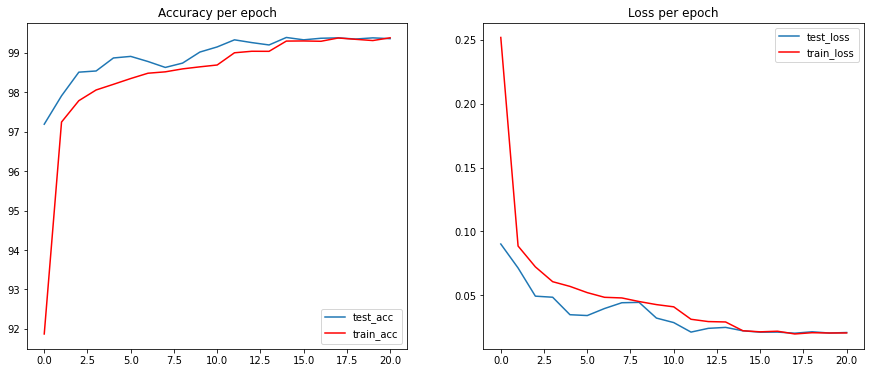

In [ ]:
'''optimizer = optim.SGD(model_GN.parameters(), lr=0.01, momentum=0.9)
for epoch in range(15, 20):
    print("Epoch: ", epoch)
    train(model_GN, device, train_loader, optimizer, scheduler, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model_GN, device, test_loader)

training_curves()'''

In [ ]:
model_training_loss["GN_model"] = hist_train_loss
model_training_acc["GN_model"] = hist_train_acc
model_testing_loss["GN_model"] = hist_test_loss
model_testing_acc["GN_model"] = hist_test_acc

hist_test_loss = []
hist_test_acc = []
hist_train_loss = []
hist_train_acc = []

## Training with batch norm

In [ ]:
model_BN = model.Net3_1("BN").to(device)
summary(model_BN, input_size=(1, 28, 28))

Normalization Technique:  BN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
             ReLU-11            [-1, 8, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           1,152
             ReLU-13           [-1, 16, 10, 10]               0
      Batc

Epoch:  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training Average loss: 0.253621, Accuracy = (91.830000%)
learning rate 0.1
Test set: Average loss: 0.061201, Accuracy: 9784/10000 (97.840000%)

Epoch:  2
Training Average loss: 0.080995, Accuracy = (97.518333%)
learning rate 0.1
Test set: Average loss: 0.056213, Accuracy: 9812/10000 (98.120000%)

Epoch:  3
Training Average loss: 0.065905, Accuracy = (98.026667%)
learning rate 0.1
Test set: Average loss: 0.040024, Accuracy: 9887/10000 (98.870000%)

Epoch:  4
Training Average loss: 0.053409, Accuracy = (98.391667%)
learning rate 0.1
Test set: Average loss: 0.036989, Accuracy: 9883/10000 (98.830000%)

Epoch:  5
Training Average loss: 0.049135, Accuracy = (98.445000%)
learning rate 0.1
Test set: Average loss: 0.026875, Accuracy: 9920/10000 (99.200000%)

Epoch:  6
Training Average loss: 0.048119, Accuracy = (98.506667%)
learning rate 0.1
Test set: Average loss: 0.025197, Accuracy: 9915/10000 (99.150000%)

Epoch:  7
Training Average loss: 0.042213, Accuracy = (98.620000%)
learning rate 0.1
T

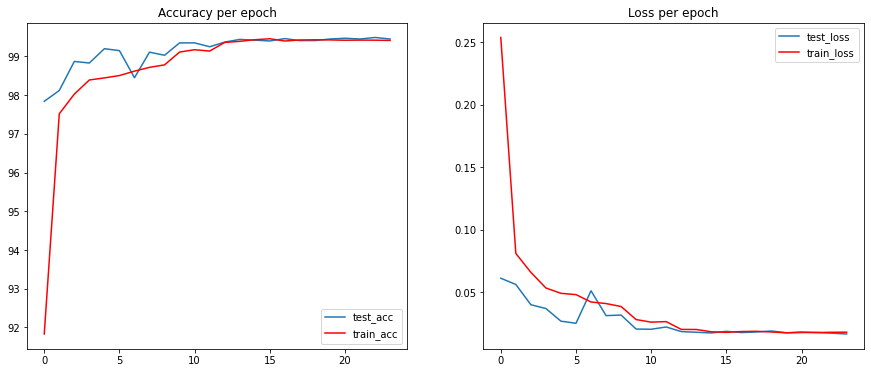

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR

optimizer = optim.SGD(model_BN.parameters(), lr=0.1, momentum=0.9,)

scheduler =ReduceLROnPlateau(optimizer=optimizer, patience=2, verbose=True)

for epoch in range(1, 10):
    print("Epoch: ", epoch)
    train(model_BN, device, train_loader, optimizer, scheduler, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model_BN, device, test_loader)

optimizer = optim.SGD(model_BN.parameters(), lr=0.05, momentum=0.9)
for epoch in range(10, 13):
    print("Epoch: ", epoch)
    train(model_BN, device, train_loader, optimizer, scheduler, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model_BN, device, test_loader)

optimizer = optim.SGD(model_BN.parameters(), lr=0.01, momentum=0.9)
for epoch in range(13, 25):
    print("Epoch: ", epoch)
    train(model_BN, device, train_loader, optimizer, scheduler, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model_BN, device, test_loader)

training_curves()

Epoch:  15


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training Average loss: 0.020735, Accuracy = (99.343333%)
learning rate 0.01
Test set: Average loss: 0.016343, Accuracy: 9945/10000 (99.450000%)

Epoch:  16
Training Average loss: 0.020301, Accuracy = (99.333333%)
learning rate 0.01
Test set: Average loss: 0.016619, Accuracy: 9943/10000 (99.430000%)

Epoch:  17
Training Average loss: 0.020509, Accuracy = (99.378333%)
learning rate 0.01
Test set: Average loss: 0.015894, Accuracy: 9942/10000 (99.420000%)

Epoch:  18
Training Average loss: 0.020599, Accuracy = (99.341667%)
learning rate 0.01
Test set: Average loss: 0.016810, Accuracy: 9942/10000 (99.420000%)

Epoch:  19
Epoch    19: reducing learning rate of group 0 to 1.0000e-02.
Training Average loss: 0.020897, Accuracy = (99.316667%)
learning rate 0.01
Test set: Average loss: 0.017813, Accuracy: 9937/10000 (99.370000%)



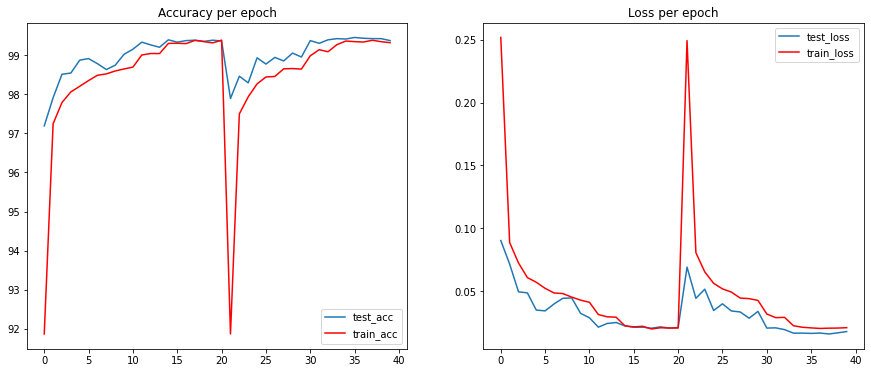

In [ ]:
'''optimizer = optim.SGD(model_BN.parameters(), lr=0.01, momentum=0.9)
for epoch in range(15, 20):
    print("Epoch: ", epoch)
    train(model_BN, device, train_loader, optimizer, scheduler, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model_BN, device, test_loader)

training_curves()'''

In [ ]:
model_training_loss["BN_model"] = hist_train_loss
model_training_acc["BN_model"] = hist_train_acc
model_testing_loss["BN_model"] = hist_test_loss
model_testing_acc["BN_model"] = hist_test_acc

hist_test_loss = []
hist_test_acc = []
hist_train_loss = []
hist_train_acc = []

## Training with Layer norm

In [ ]:
model_LN = model.Net3_1("LN").to(device)
summary(model_BN, input_size=(1, 28, 28))

Normalization Technique:  LN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
             ReLU-11            [-1, 8, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           1,152
             ReLU-13           [-1, 16, 10, 10]               0
      Batc

Epoch:  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training Average loss: 0.336652, Accuracy = (88.760000%)
learning rate 0.1
Test set: Average loss: 0.094690, Accuracy: 9704/10000 (97.040000%)

Epoch:  2
Training Average loss: 0.088468, Accuracy = (97.266667%)
learning rate 0.1
Test set: Average loss: 0.055544, Accuracy: 9808/10000 (98.080000%)

Epoch:  3
Training Average loss: 0.067038, Accuracy = (97.931667%)
learning rate 0.1
Test set: Average loss: 0.035939, Accuracy: 9880/10000 (98.800000%)

Epoch:  4
Training Average loss: 0.055879, Accuracy = (98.288333%)
learning rate 0.1
Test set: Average loss: 0.030106, Accuracy: 9893/10000 (98.930000%)

Epoch:  5
Training Average loss: 0.049974, Accuracy = (98.423333%)
learning rate 0.1
Test set: Average loss: 0.030671, Accuracy: 9896/10000 (98.960000%)

Epoch:  6
Training Average loss: 0.042664, Accuracy = (98.648333%)
learning rate 0.1
Test set: Average loss: 0.029251, Accuracy: 9897/10000 (98.970000%)

Epoch:  7
Training Average loss: 0.039466, Accuracy = (98.735000%)
learning rate 0.1
T

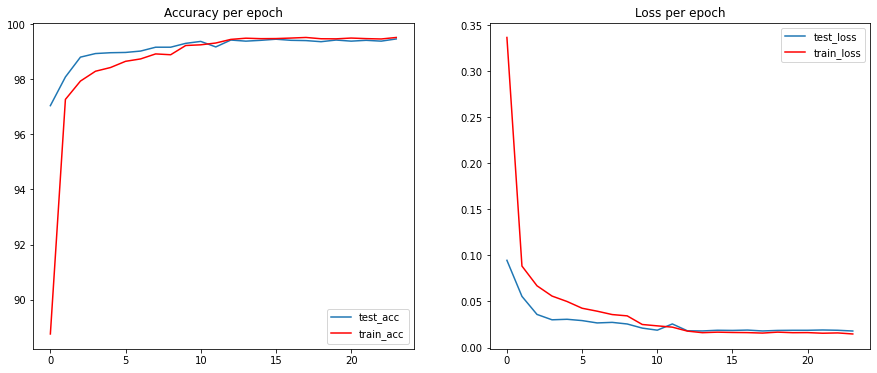

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR

optimizer = optim.SGD(model_LN.parameters(), lr=0.1, momentum=0.9,)

scheduler =ReduceLROnPlateau(optimizer=optimizer, patience=2, verbose=True)

for epoch in range(1, 10):
    print("Epoch: ", epoch)
    train(model_LN, device, train_loader, optimizer, scheduler, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model_LN, device, test_loader)

optimizer = optim.SGD(model_LN.parameters(), lr=0.05, momentum=0.9)
for epoch in range(10, 13):
    print("Epoch: ", epoch)
    train(model_LN, device, train_loader, optimizer, scheduler, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model_LN, device, test_loader)

optimizer = optim.SGD(model_LN.parameters(), lr=0.01, momentum=0.9)
for epoch in range(13, 25):
    print("Epoch: ", epoch)
    train(model_LN, device, train_loader, optimizer, scheduler, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model_LN, device, test_loader)

training_curves()

In [ ]:
model_training_loss["LN_model"] = hist_train_loss
model_training_acc["LN_model"] = hist_train_acc
model_testing_loss["LN_model"] = hist_test_loss
model_testing_acc["LN_model"] = hist_test_acc

Text(0.5, 1.0, 'TEST ACCURACY')

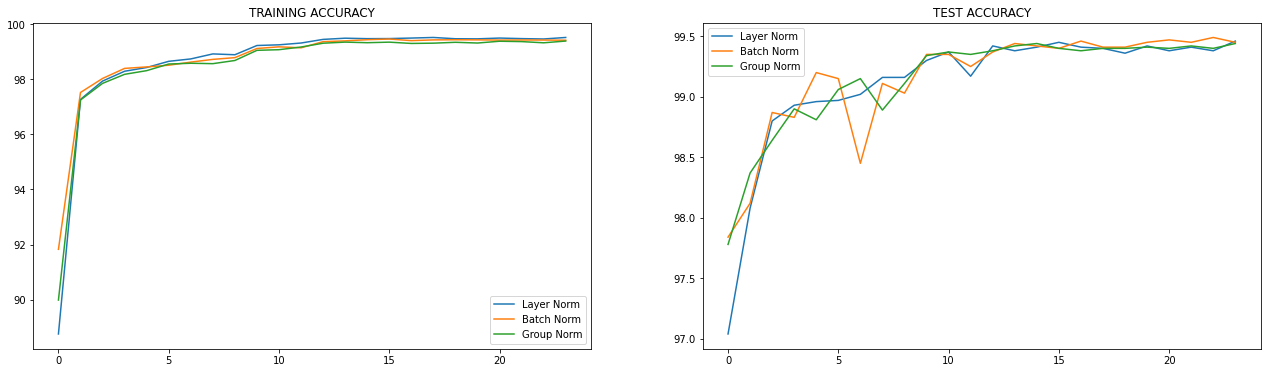

In [ ]:
plt.rcParams['figure.figsize'] = [22, 6]

plt.subplot(1,2,1)
plt.plot(model_training_acc["LN_model"])
plt.plot(model_training_acc["BN_model"])
plt.plot(model_training_acc["GN_model"])
plt.legend(["Layer Norm", "Batch Norm", "Group Norm"])
plt.title("TRAINING ACCURACY")

plt.subplot(1,2,2)
plt.plot(model_testing_acc["LN_model"])
plt.plot(model_testing_acc["BN_model"])
plt.plot(model_testing_acc["GN_model"])
plt.legend(["Layer Norm", "Batch Norm", "Group Norm"])
plt.title("TEST ACCURACY")

Text(0.5, 1.0, 'TEST LOSS')

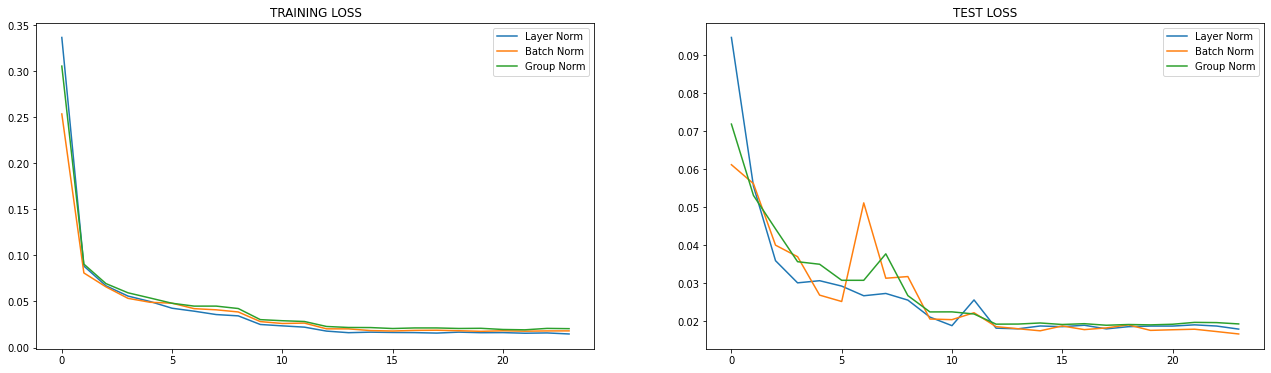

In [ ]:
plt.rcParams['figure.figsize'] = [22, 6]

plt.subplot(1,2,1)
plt.plot(model_training_loss["LN_model"])
plt.plot(model_training_loss["BN_model"])
plt.plot(model_training_loss["GN_model"])
plt.legend(["Layer Norm", "Batch Norm", "Group Norm"])
plt.title("TRAINING LOSS")

plt.subplot(1,2,2)
plt.plot(model_testing_loss["LN_model"])
plt.plot(model_testing_loss["BN_model"])
plt.plot(model_testing_loss["GN_model"])
plt.legend(["Layer Norm", "Batch Norm", "Group Norm"])
plt.title("TEST LOSS")

# Check Misclassified Images

In [ ]:
def imageshow(img):
    # img = img / 2 + 0.5      #unnormalize
    img[0] = img[0]*0.1307 + 0.3081
    #img[1] = img[1]*0.24348513 + 0.48215841
    #img[2] = img[2]*0.26158784 + 0.44653091
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    img[0] = img[0]*0.1307 + 0.3081
    #img[1] = img[1]*0.24348513 + 0.48215841
    #img[2] = img[2]*0.26158784 + 0.44653091
    npimg = img.numpy()
    image = np.transpose(npimg, (1, 2, 0))
    plt.imshow(image.reshape(28,28))
    plt.grid(b=None)
    return image

## MisClassified Images with Group Norm

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


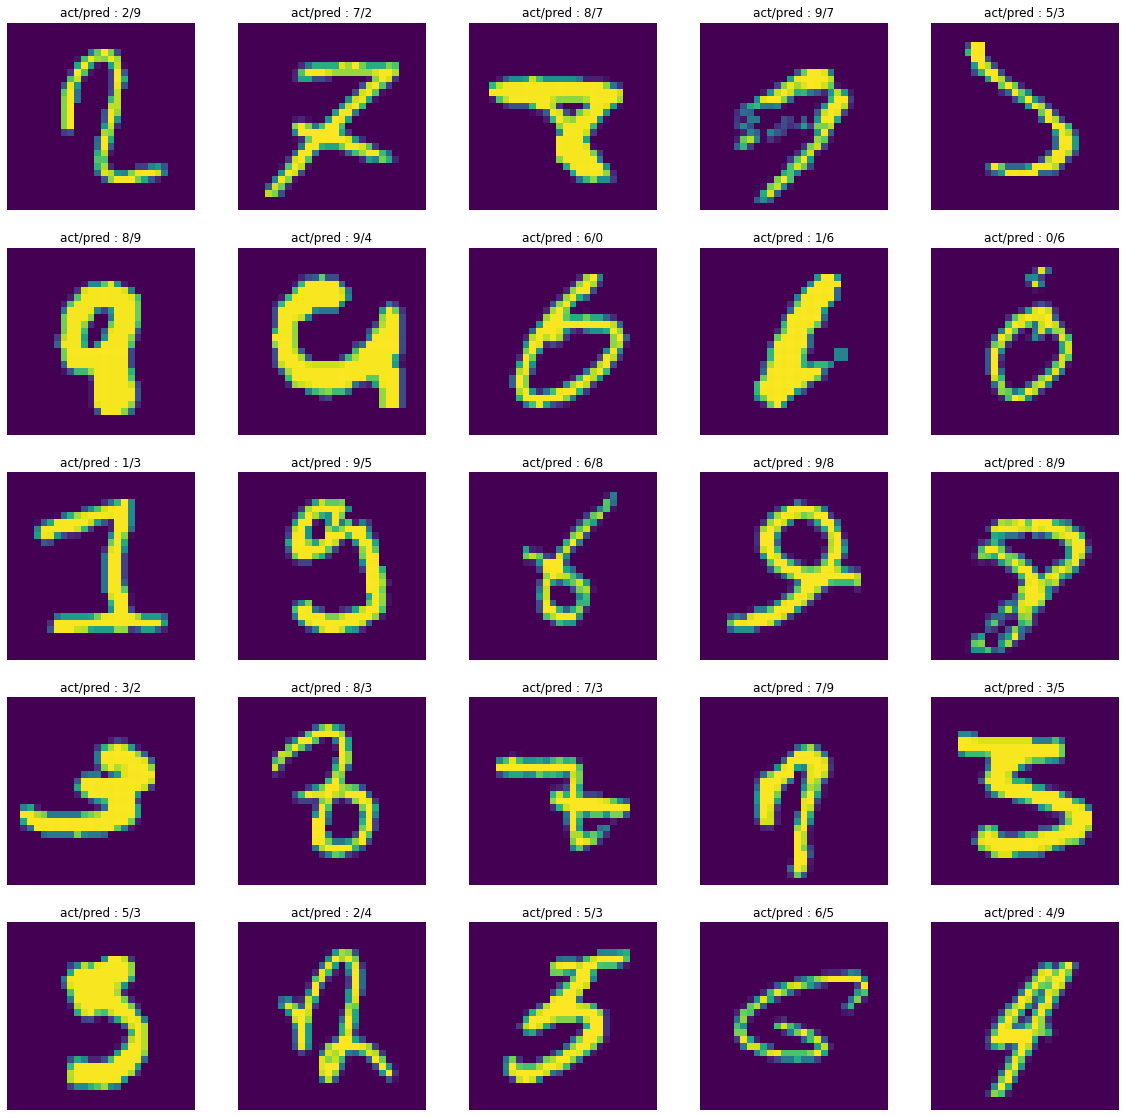

In [ ]:
classes = ('0','1','2','3','4','5','6','7','8','9')

model_GN.eval()

figure = plt.figure(figsize=(20, 20))
num_of_images = 25
index = 1

misclass_img_list = []
untrans_img=[]

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(
            device), target.to(device)
        output = model_GN(data)
        pred = output.argmax(dim=1, keepdim=True)
        act = target.view_as(pred)
        # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa
        bool_vec = ~pred.eq(act)

        # now extract the index number from the tensor which has 'true'
        idx = list(
            np.where(bool_vec.cpu().numpy())[0])

        if idx:  # if not a blank list
            idx_list = idx
            # print(data[idx_list[0]].shape)
            if index < num_of_images+1:
                plt.subplot(5, 5, index)
                plt.axis('off')
                titl = 'act/pred : ' + \
                    str(classes[target[idx[0]].cpu().item(
                    )]) + '/' + str(classes[pred[idx[0]].cpu().item()])
                # prints the 1st index of each batch.
            
                img = data[idx[0]].cpu()
                untrans_img.append(img)
                image = imshow(img)
                misclass_img_list.append(image)
                                  


                plt.title(titl)
                index += 1

## MisClassified Images with Batch Norm

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


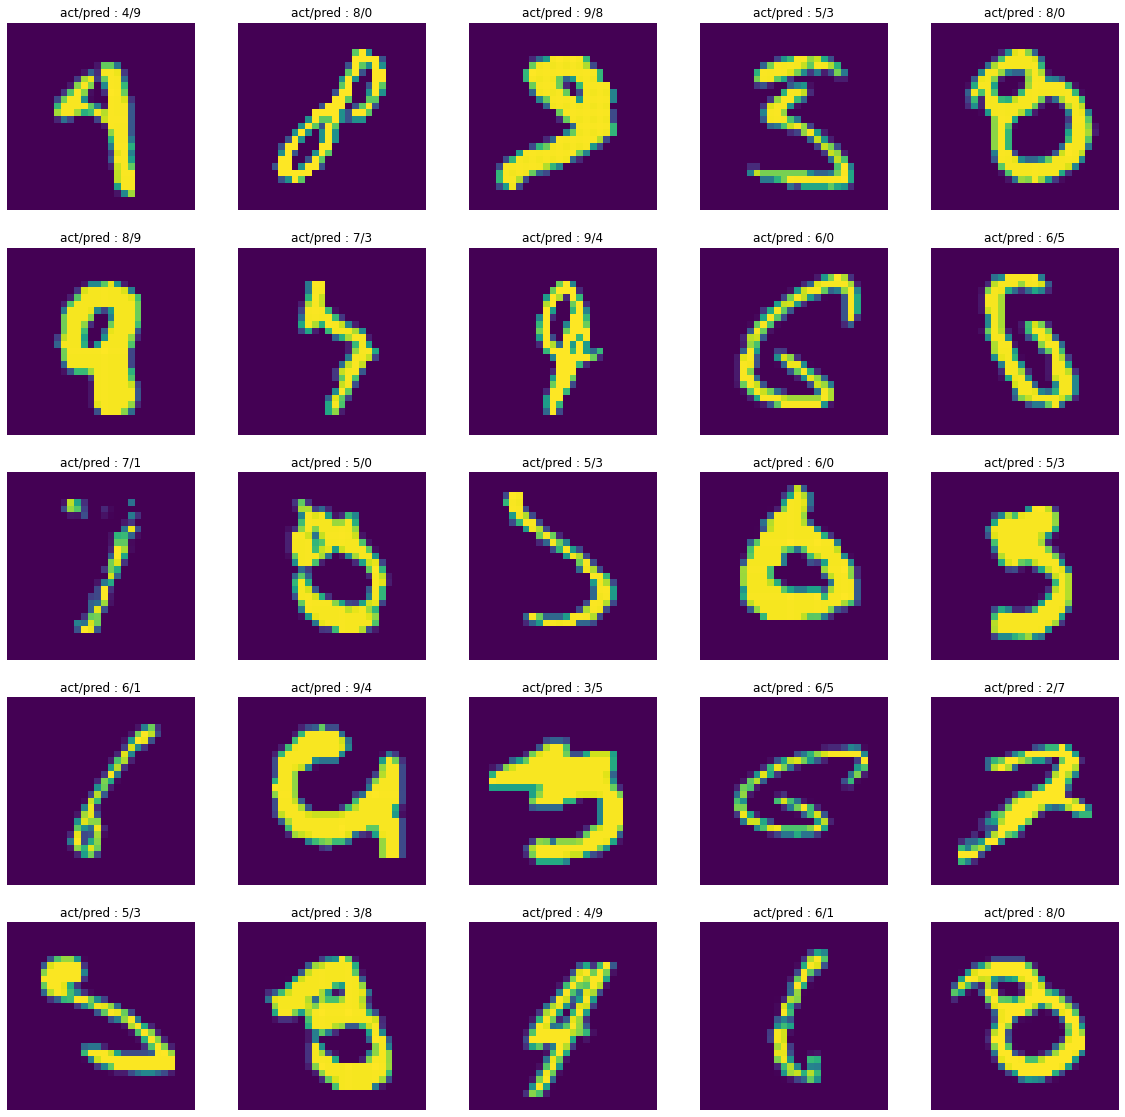

In [ ]:
classes = ('0','1','2','3','4','5','6','7','8','9')

model_BN.eval()

figure = plt.figure(figsize=(20, 20))
num_of_images = 25
index = 1

misclass_img_list = []
untrans_img=[]

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(
            device), target.to(device)
        output = model_BN(data)
        pred = output.argmax(dim=1, keepdim=True)
        act = target.view_as(pred)
        # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa
        bool_vec = ~pred.eq(act)

        # now extract the index number from the tensor which has 'true'
        idx = list(
            np.where(bool_vec.cpu().numpy())[0])

        if idx:  # if not a blank list
            idx_list = idx
            # print(data[idx_list[0]].shape)
            if index < num_of_images+1:
                plt.subplot(5, 5, index)
                plt.axis('off')
                titl = 'act/pred : ' + \
                    str(classes[target[idx[0]].cpu().item(
                    )]) + '/' + str(classes[pred[idx[0]].cpu().item()])
                # prints the 1st index of each batch.
            
                img = data[idx[0]].cpu()
                untrans_img.append(img)
                image = imshow(img)
                misclass_img_list.append(image)
                                  


                plt.title(titl)
                index += 1

## MisClassified Images with Layer Norm

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


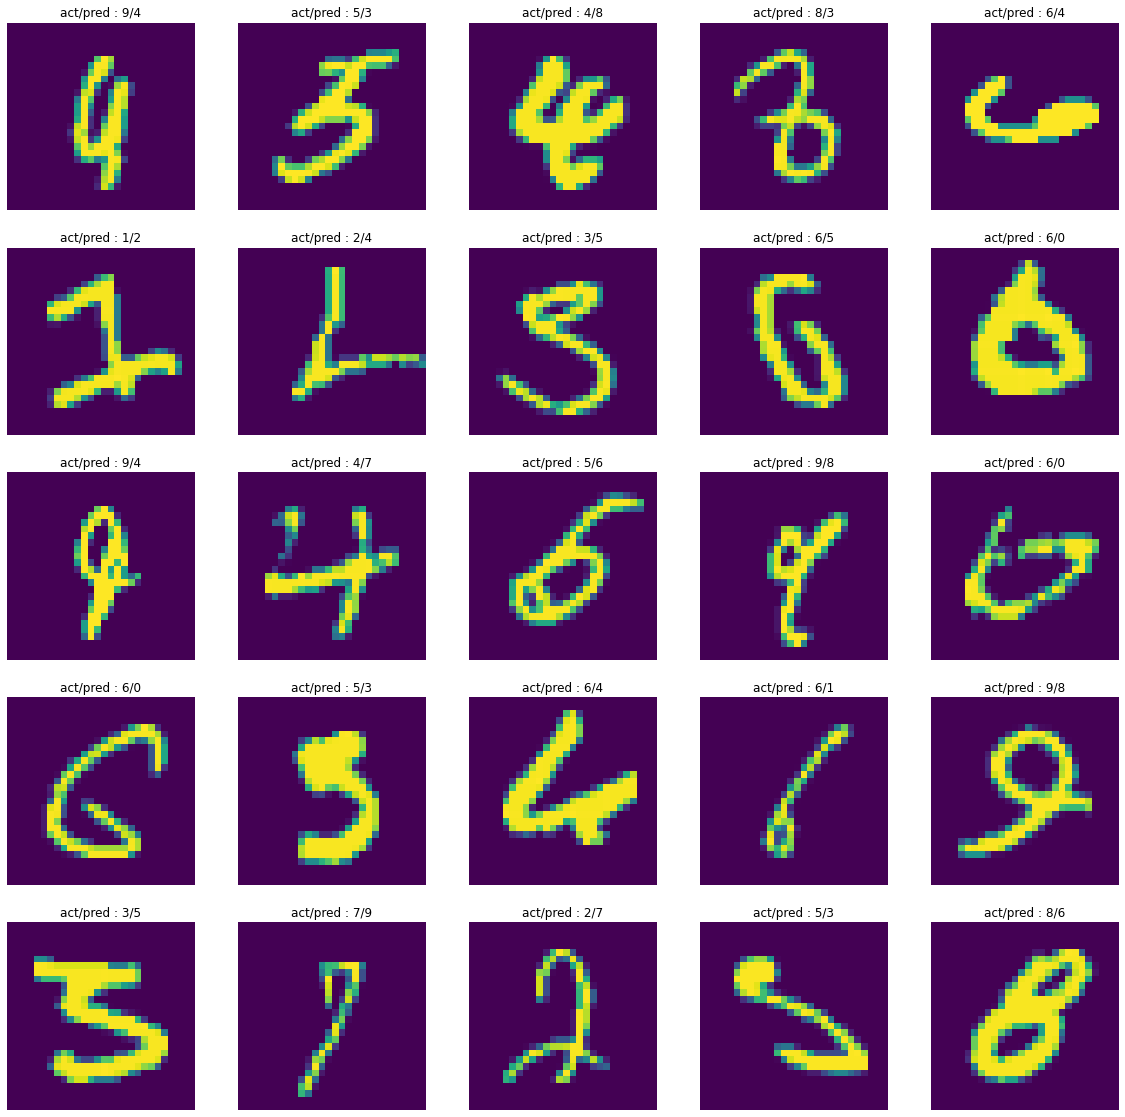

In [ ]:
classes = ('0','1','2','3','4','5','6','7','8','9')

model_LN.eval()

figure = plt.figure(figsize=(20, 20))
num_of_images = 25
index = 1

misclass_img_list = []
untrans_img=[]

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(
            device), target.to(device)
        output = model_LN(data)
        pred = output.argmax(dim=1, keepdim=True)
        act = target.view_as(pred)
        # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa
        bool_vec = ~pred.eq(act)

        # now extract the index number from the tensor which has 'true'
        idx = list(
            np.where(bool_vec.cpu().numpy())[0])

        if idx:  # if not a blank list
            idx_list = idx
            # print(data[idx_list[0]].shape)
            if index < num_of_images+1:
                plt.subplot(5, 5, index)
                plt.axis('off')
                titl = 'act/pred : ' + \
                    str(classes[target[idx[0]].cpu().item(
                    )]) + '/' + str(classes[pred[idx[0]].cpu().item()])
                # prints the 1st index of each batch.
            
                img = data[idx[0]].cpu()
                untrans_img.append(img)
                image = imshow(img)
                misclass_img_list.append(image)
                                  


                plt.title(titl)
                index += 1